# Storytelling:
Diante da concessão de créditos para clientes, uma empresa da região norte do Brasil deseja automatizar a disponibilidade de crédito para o cliente a partir do Score do cliente. Sabe-se que, o Score real do cliente existe, mas o setor de crédito deseja estimar com base em modelos preditivos o Score do consumidor.


### Objetivo:
* Encontrar o melhor modelo de aprendizado para estimar o Score do consumidor.

### Metodolodia:

* Entender características gerais de empréstimo fornecido ao consumidor;
* Criar experimentação baseline com algoritmos de previsão;
* Verificar qual modelo atende, de acordo com as métricas, a melhor previsão de Score fornecida ao cliente 

## Features

* **credit.policy** (cirterio de concessão de crédito): 1 - Atende os critérios / 0 - Não atende os critéiros
* **purpose** (finalidade do empréstimo): Atributos categóricos divididos em:
  - Cartão de crédito
  - Concolidação de dívidas
  - Gasto educacional
  - Compra acima do limite
  - Startup (empreendimento)
  - outros
* **int.rate** ( taxa de juros)
* **installment** (parcela mensal): Valor da parcela do empréstimos caso seja concedido
* **log.annual.inc**: Renda anual do usuário
* **dti**: Montante da dívida pelo rendimento anual
* **fico** : Score de crédito
* **days.with.cr.line**: Dias com linha de crédito disponível
* **revol.bal** : Valor não pago no final do ciclo de faturamento do cartão de crédito
* **revol.util** : Montante da linha de crédito utilizada em relação ao crédito total disponível
* **inq.last.6mths** : Consulta de credores nos ultimos 6 meses
* **delinq.2yrs** : O número de vezes que o mutuário esteve com mais de 30 dias de atraso em um pagamento nos últimos 2 anos.
* **pub.rec** : Número de pedidos de falência, ônus fiscais ou sentenças.
* **not.fully.paid** : Se o empréstimo concedido foi totalmente pago ou não



# Bibliotecas

In [286]:
import xgboost

import pandas                as pd
import numpy                 as np
import matplotlib.pyplot     as plt
import seaborn               as sn

import statsmodels.api       as sm
import statsmodels.formula.api as smf

from sklearn.metrics              import r2_score
from sklearn.pipeline             import make_pipeline
from sklearn.preprocessing        import scale, StandardScaler, MinMaxScaler
from sklearn                      import linear_model
from google.colab                 import drive

import warnings
warnings.filterwarnings("ignore")

In [287]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Leitura e tratamento de dados

## Leitura e visualização de dados

In [288]:
df_emprestimos = pd.read_csv('/content/gdrive/MyDrive/Datasets/emprestimos/loan_data.csv')
df_emprestimos.shape

(9578, 14)

In [289]:
df_emprestimos.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [290]:
df_emprestimos.tail()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
9573,0,all_other,0.1461,344.76,12.180755,10.39,672,10474.000000,215372,82.1,2,0,0,1
9574,0,all_other,0.1253,257.70,11.141862,0.21,722,4380.000000,184,1.1,5,0,0,1
9575,0,debt_consolidation,0.1071,97.81,10.596635,13.09,687,3450.041667,10036,82.9,8,0,0,1
9576,0,home_improvement,0.1600,351.58,10.819778,19.18,692,1800.000000,0,3.2,5,0,0,1
9577,0,debt_consolidation,0.1392,853.43,11.264464,16.28,732,4740.000000,37879,57.0,6,0,0,1


## Análise exploratória de dados

In [291]:
df_emprestimos.describe()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
count,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9.578000e+03,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000
mean,0.804970,0.122640,319.089413,10.932117,12.606679,710.846314,4560.767197,1.691396e+04,46.799236,1.577469,0.163708,0.062122,0.160054
std,0.396245,0.026847,207.071301,0.614813,6.883970,37.970537,2496.930377,3.375619e+04,29.014417,2.200245,0.546215,0.262126,0.366676
min,0.000000,0.060000,15.670000,7.547502,0.000000,612.000000,178.958333,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.103900,163.770000,10.558414,7.212500,682.000000,2820.000000,3.187000e+03,22.600000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.122100,268.950000,10.928884,12.665000,707.000000,4139.958333,8.596000e+03,46.300000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,0.140700,432.762500,11.291293,17.950000,737.000000,5730.000000,1.824950e+04,70.900000,2.000000,0.000000,0.000000,0.000000
max,1.000000,0.216400,940.140000,14.528354,29.960000,827.000000,17639.958330,1.207359e+06,119.000000,33.000000,13.000000,5.000000,1.000000


Uma das cracaterísticas que iremos tentar prever neste repositório é a relação do Score disponível do usuário vinculado a taxa de juros concedida no empréstimo. Diante disso, buscamos analisar a correlação dessas duas festures, como podemos visualizar abaixo:

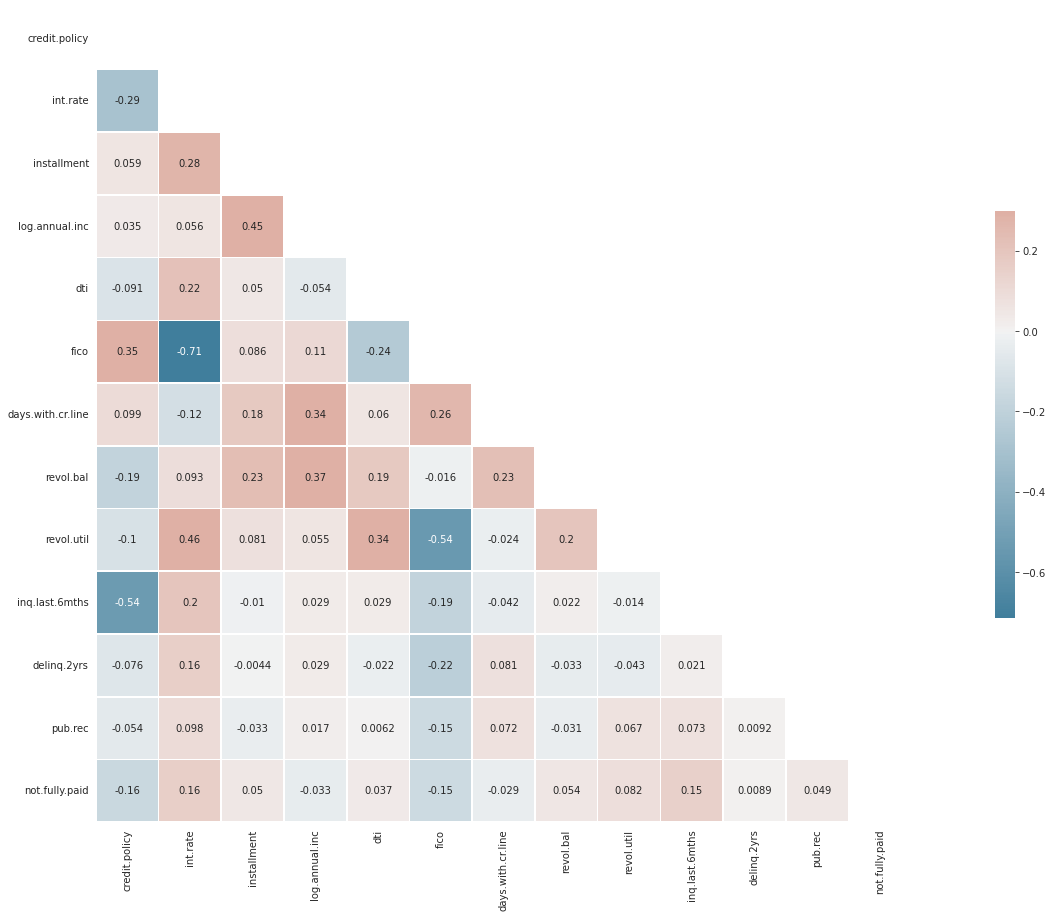

In [292]:
corr = df_emprestimos.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(30, 15))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True,
            square=True, linewidths=.6, cbar_kws={"shrink": .5})

In [293]:
df_emprestimos[['fico','int.rate']].describe()

,fico,int.rate
count,9578.000000,9578.000000
mean,710.846314,0.122640
std,37.970537,0.026847
min,612.000000,0.060000
25%,682.000000,0.103900
50%,707.000000,0.122100
75%,737.000000,0.140700
max,827.000000,0.216400


# Experimentações de modelos com desenvolvimento de features

* Neste tópico, o objetivo é encontrarmos um norte para testarmos um dataframe que possui a melhor métrica de previsão para o Score do cliente. Por conseguinte, iremos criar um pipeline de linha de base com o melhor dataframe encontrado.

## Regressão linear simples

* Encontrando correlação de Score de clientes com features disponíveis

#### Comparação dos dados reais pelos previstos 

In [294]:
#Separamos as variáveis
X = df_emprestimos['int.rate'].values.reshape((len(df_emprestimos)), 1)
Y = df_emprestimos['fico'].values

#Intanciamos o modelo de regressão linear
modelo_simples = linear_model.LinearRegression(normalize = False, fit_intercept=True)

#Treinamento
modelo_simples.fit(X, Y)

#Verificamos as variaveis preditas
valores_previstos = modelo_simples.predict(X)

#Adicionamos os dados previstos em um Dataframe para compararmos o Score real e o Score dado pelo modelo
table_preview = df_emprestimos[['int.rate','fico']]
table_preview['predict_simples'] = valores_previstos

table_preview.head(5)

,int.rate,fico,predict_simples
0,0.1189,737,714.627491
1,0.1071,707,726.557214
2,0.1357,682,697.642801
3,0.1008,712,732.926473
4,0.1426,667,690.666946


## [Exp. 2] Regressão Linear Múltipla - padronização de dados

In [295]:
#Realizamos o pre-processamento da feature de categorias
df_emprestimos['purpose_cat'] = df_emprestimos['purpose'].astype(str).astype('category').cat.codes

In [296]:
X = df_emprestimos.drop(['fico','purpose'], axis=1).values
y = df_emprestimos['fico'].values

X.shape, y.shape

((9578, 13), (9578,))

In [297]:
#Intanciamos o modelo de regressão linear
modelo_multiplo = linear_model.LinearRegression(normalize = False, fit_intercept=True)

#Padronização de dados
linear_standardscaler = StandardScaler()
model_standardscaler = make_pipeline(linear_standardscaler, modelo_multiplo)

#Treinamento
model_standardscaler.fit(X, y)

#Verificamos as variaveis preditas
valores_multiplos_previstos_padronizados = model_standardscaler.predict(X)

In [298]:
#Adicionamos os dados previstos em um Dataframe para compararmos o Score real e o Score dado pelo modelo
table_preview['predict_multiplo_padronizado'] = valores_multiplos_previstos_padronizados

In [299]:
table_preview.head()

,int.rate,fico,predict_simples,predict_multiplo_padronizado
0,0.1189,737,714.627491,738.190214
1,0.1071,707,726.557214,708.717941
2,0.1357,682,697.642801,714.577079
3,0.1008,712,732.926473,715.008389
4,0.1426,667,690.666946,680.192577


In [300]:
# É interessante saber por cima como foram as métricas vinculadas ao modelo de Regressão Linear
print('Intercept:', modelo_multiplo.intercept_)
print('Coeficiente : ', modelo_multiplo.coef_)
print('Score do modelo : ', modelo_multiplo.score(X, y))

Intercept: 710.8463144706619
Coeficiente :  [  4.19163854 -21.62194941   8.25625518  -0.11333295  -1.50378349
   5.52822568   1.08392898 -10.13734188   0.14885192  -5.303624
  -2.58628537  -0.95548096   2.33000211]
Score do modelo :  -2694645.1104866816


## [Exp. 2.1] Regressão Linear Múltipla



In [301]:
#Dados de treino e teste
X = df_emprestimos.drop(['fico','purpose'], axis=1)
y = df_emprestimos['fico']

#Adicionamos uma constante aos dados de treino
X_sts = sm.add_constant(X)

In [302]:
#Instanciamos o método
modelo_sts = sm.OLS(y, X_sts)

#Treinamos o modelo
modelo_sts = modelo_sts.fit()

In [303]:
print(modelo_sts.summary())

                            OLS Regression Results                            
Dep. Variable:                   fico   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     1739.
Date:                Tue, 27 Dec 2022   Prob (F-statistic):               0.00
Time:                        23:16:27   Log-Likelihood:                -42613.
No. Observations:                9578   AIC:                         8.525e+04
Df Residuals:                    9564   BIC:                         8.535e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               798.6917      4.63

Agora, como desejaríamos ver, trouxemos as caraterísticas das métricas totais do modelo de regressão múltipla

Os dados de características de concessão de crédito explicam 70% da pontuação do Score do cliente
Temos duas variáveis que podemos retirar do nosso conjunto de dados a partir do valor -p, de maneira respectiva, temos o quarto atributo e o nono atributo, que possuem valor que indica uma não associação, isto é, talvez ocorra uma "sorte".

* log.annual.inc:  Renda anual do usuário
* inq.last.6mths:  Consulta de credores nos ultimos 6 meses

### Pré-processamento

Para utilizarmos todos os atributos vinculados ao Score do cliente, necessita-se que valores com tipos primitivos estejam dentro das características ideais de entrada do modelo.

#### Feature engineering

In [304]:
purpose_features = pd.get_dummies(df_emprestimos.purpose, prefix='purpose_')
purpose_features.head()

,purpose__all_other,purpose__credit_card,purpose__debt_consolidation,purpose__educational,purpose__home_improvement,purpose__major_purchase,purpose__small_business
0,0,0,1,0,0,0,0
1,0,1,0,0,0,0,0
2,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0
4,0,1,0,0,0,0,0


In [305]:
df_emprestimos_dummies = pd.concat([df_emprestimos, purpose_features], axis=1).drop('purpose', axis=1)
df_emprestimos_dummies.head()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,...,pub.rec,not.fully.paid,purpose_cat,purpose__all_other,purpose__credit_card,purpose__debt_consolidation,purpose__educational,purpose__home_improvement,purpose__major_purchase,purpose__small_business
0,1,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,...,0,0,2,0,0,1,0,0,0,0
1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,...,0,0,1,0,1,0,0,0,0,0
2,1,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,...,0,0,2,0,0,1,0,0,0,0
3,1,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,...,0,0,2,0,0,1,0,0,0,0
4,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,...,0,0,1,0,1,0,0,0,0,0


In [306]:
X = df_emprestimos_dummies.drop(['fico','log.annual.inc','inq.last.6mths'], axis=1)
y = df_emprestimos_dummies['fico']

#Adicionamos uma constante aos dados de treino
X_sts = sm.add_constant(X)
modelo_sts = sm.OLS(y, X_sts)

#Treinamos o modelo
modelo_sts = modelo_sts.fit()

In [307]:
print(modelo_sts.summary())

                            OLS Regression Results                            
Dep. Variable:                   fico   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     1466.
Date:                Tue, 27 Dec 2022   Prob (F-statistic):               0.00
Time:                        23:16:27   Log-Likelihood:                -42489.
No. Observations:                9578   AIC:                         8.501e+04
Df Residuals:                    9561   BIC:                         8.513e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

## [Exp. 2.2] Regressão Linear Múltipla Dummies - Escalonamento

* Com a utilização de dummies values, queremos descobrir quais serão as features importantes para nosso modelo




In [308]:
#Retiramos features que demonstram pouca importância para o valor do Score
df_emprestimos_dummies = df_emprestimos_dummies.drop(['log.annual.inc','inq.last.6mths'], axis=1)

In [309]:
#Separar dados de treino e teste
X_dumm = df_emprestimos_dummies.drop(['fico'], axis=1)
y_dumm = df_emprestimos_dummies['fico']

X_dumm.shape, y_dumm.shape

((9578, 18), (9578,))

In [310]:
#Instanciamos o modelo
modelo_multiplo_dummies_scaler = linear_model.LinearRegression(normalize = False, fit_intercept=True)

#Padronização de dados
normalizer_scaler = MinMaxScaler()
stand_coef_linear_reg = make_pipeline(normalizer_scaler, modelo_multiplo_dummies_scaler)

In [311]:
#Treinamos o modelo
stand_coef_linear_reg.fit(X_dumm, y_dumm)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('linearregression', LinearRegression(normalize=False))])

In [312]:
#Iremos imprimir as principais variáveis que possuem grau de importância na previsão do Score do cliente
for coef, var in sorted(zip(map(abs, stand_coef_linear_reg.steps[1][1].coef_), df_emprestimos_dummies[:-1]), reverse=True):
  print("%6.3f %s" % (coef, var))

128.863 int.rate
124.180 revol.util
47.269 delinq.2yrs
38.675 revol.bal
38.222 installment
37.876 fico
25.928 days.with.cr.line
10.227 credit.policy
 9.410 purpose__major_purchase
 5.128 not.fully.paid
 4.289 dti
 3.968 purpose__credit_card
 3.567 purpose__debt_consolidation
 3.217 pub.rec
 2.527 purpose__all_other
 1.561 purpose_cat
 0.895 purpose__home_improvement
 0.013 purpose__educational


In [313]:
#Verificamos as variaveis preditas
valores_multiplos_previstos_escalonados = stand_coef_linear_reg.predict(X)

#Adicionamos os dados previstos em um Dataframe para compararmos o Score real e o Score dado pelo modelo
table_preview['predict_multiplo_padronizado'] = valores_multiplos_previstos_escalonados

In [314]:
table_preview.head(10)

,int.rate,fico,predict_simples,predict_multiplo_padronizado
0,0.1189,737,714.627491,736.799164
1,0.1071,707,726.557214,708.867371
2,0.1357,682,697.642801,711.020513
3,0.1008,712,732.926473,712.642569
4,0.1426,667,690.666946,679.090285
5,0.0788,727,755.168329,743.547334
6,0.1496,667,683.589992,660.891530
7,0.1114,722,722.209942,709.331500
8,0.1134,682,720.187955,714.265185
9,0.1221,707,711.392312,707.365009


In [315]:
# É interessante saber por cima como foram as métricas vinculadas ao modelo de Regressão Linear
print('Intercept:', modelo_multiplo_dummies_scaler.intercept_)
print('Coeficiente : ', modelo_multiplo_dummies_scaler.coef_)
print('Score do modelo : ', modelo_multiplo_dummies_scaler.score(X, y))

Intercept: 750.9844680594714
Coeficiente :  [ 1.02273091e+01 -1.28862793e+02  3.82223497e+01 -4.28886377e+00
  3.78760256e+01  2.59283399e+01 -3.86750516e+01 -1.24180434e+02
 -4.72690928e+01 -3.21695559e+00  5.12757614e+00  1.56100447e+00
 -2.52738117e+00 -3.96804729e+00 -3.56703181e+00 -1.31334895e-02
 -8.95026201e-01  9.40961550e+00]
Score do modelo :  -834127453.6946563


# Experimentações de modelos de linhas de base

Como primeiro aspecto da experimentação de modelos de linha de base, utilizaremos inicialmente quatro modelos de regressão, a regressão múltipla, Regressão de Ridge, Regressão Lasso e XGBoost, o objetivo destas comparações é encontrar a menor taxa de erro dentro os algoritmos treinados e testados. Sabe-se que, iremos utilizar o dataframe que evidenciamos as duas features que não apresentam importância para o Score do cliente.

## Bibliotecas 

In [316]:
from sklearn.pipeline             import Pipeline
from sklearn.model_selection      import KFold
from sklearn.model_selection      import cross_val_score
from sklearn                      import ensemble

In [317]:
df_emprestimos_dummies.shape

(9578, 19)

In [318]:
df_emprestimos_dummies.head()

,credit.policy,int.rate,installment,dti,fico,days.with.cr.line,revol.bal,revol.util,delinq.2yrs,pub.rec,not.fully.paid,purpose_cat,purpose__all_other,purpose__credit_card,purpose__debt_consolidation,purpose__educational,purpose__home_improvement,purpose__major_purchase,purpose__small_business
0,1,0.1189,829.10,19.48,737,5639.958333,28854,52.1,0,0,0,2,0,0,1,0,0,0,0
1,1,0.1071,228.22,14.29,707,2760.000000,33623,76.7,0,0,0,1,0,1,0,0,0,0,0
2,1,0.1357,366.86,11.63,682,4710.000000,3511,25.6,0,0,0,2,0,0,1,0,0,0,0
3,1,0.1008,162.34,8.10,712,2699.958333,33667,73.2,0,0,0,2,0,0,1,0,0,0,0
4,1,0.1426,102.92,14.97,667,4066.000000,4740,39.5,1,0,0,1,0,1,0,0,0,0,0


## Pipeline de linhas de base (sem dummies)

Iremos criar um Pipeline de dados para que possamos automatizar a estrutura de instanciamento e treinamento do modelo


In [319]:
#Separação dos dados de treino e teste
X_default = df_emprestimos.drop(['fico', 'purpose'], axis=1)
y_default = df_emprestimos['fico']

In [320]:
#Seed, kfolds, scoring
np.random_seed = 42
folds = 10
#scoring = "neg_mean_squared_error"
scoring = "r2"

#Pipelines
pipelines = []

### Pipeline com o dataset de emprestimos com dummies padronizados
pipelines.append(('Stand_RM', 'Standard', Pipeline([('Scaler', StandardScaler()),('RM', linear_model.LinearRegression())])))
pipelines.append(('Stand_LASSO', 'Standard', Pipeline([('Scaler', StandardScaler()),('Lasso', linear_model.Ridge())]))) 
pipelines.append(('Stand_Ridge', 'Standard', Pipeline([('Scaler', StandardScaler()),('Ridge', linear_model.Lasso())]))) 
pipelines.append(('Stand_Xg', 'Standard', Pipeline([('Scaler', StandardScaler()),('Xg', ensemble.GradientBoostingRegressor())])))

### Pipeline com o dataset de emprestimos com dummies normalizados
pipelines.append(('Norm_RM', 'Standard', Pipeline([('Scaler', MinMaxScaler()),('RM', linear_model.LinearRegression())])))
pipelines.append(('Norm_LASSO', 'Standard', Pipeline([('Scaler', MinMaxScaler()),('Lasso', linear_model.Ridge())]))) 
pipelines.append(('Norm_Ridge', 'Standard', Pipeline([('Scaler', MinMaxScaler()),('Ridge', linear_model.Lasso())]))) 
pipelines.append(('Norm_Xg', 'Standard', Pipeline([('Scaler', MinMaxScaler()),('Xg', ensemble.GradientBoostingRegressor())]))) 


# Treinamento dos modelos e apresentação dos resultados
results = []
names = []
preprosetps = []

for name, prepro, pipe in pipelines:
  kfold = KFold(n_splits=folds)
  cv_results = cross_val_score(pipe, X_default, y_default, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  preprosetps.append(prepro)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

Stand_RM: 0.553946 (0.271994)
Stand_LASSO: 0.553972 (0.271927)
Stand_Ridge: 0.557575 (0.244312)
Stand_Xg: 0.620800 (0.316605)
Norm_RM: 0.553946 (0.271994)
Norm_LASSO: 0.553636 (0.271414)
Norm_Ridge: 0.452512 (0.259355)
Norm_Xg: 0.621349 (0.315753)


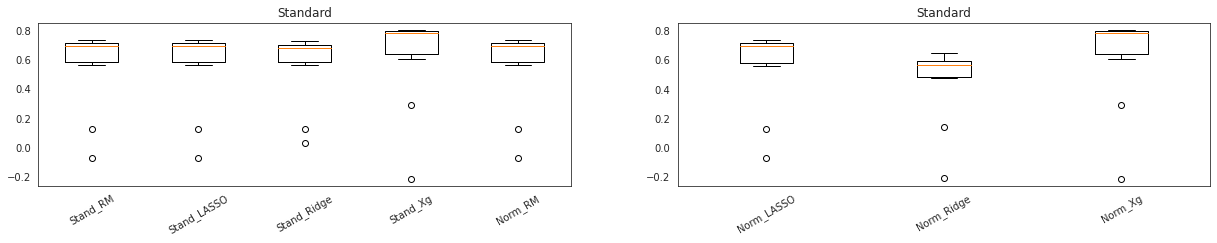

In [321]:
# boxplot de comparação dos algoritmos para cada pré-processamento
fig = plt.figure(figsize=(21,3))

for i in range(2):
  j = i*5
  k=(i+1)*5
  ax = fig.add_subplot(1,2,i+1) 
  plt.boxplot(results[j:k]) 
  ax.set_xticklabels(names[j:k])
  plt.xticks(rotation=30)
  ax.set_title(preprosetps[j])

plt.show()

## Pipeline de linhas de base (com dummies)

In [322]:
#Seed, kfolds, scoring
np.random_seed = 42
folds = 10
#scoring = "neg_mean_squared_error"
scoring = "r2"


#Pipelines
pipelines = []

### Pipeline com o dataset de emprestimos com dummies padronizados
pipelines.append(('Stand_RM', 'Standard', Pipeline([('Scaler', StandardScaler()),('RM', linear_model.LinearRegression())])))
pipelines.append(('Stand_LASSO', 'Standard', Pipeline([('Scaler', StandardScaler()),('Lasso', linear_model.Ridge())]))) 
pipelines.append(('Stand_Ridge', 'Standard', Pipeline([('Scaler', StandardScaler()),('Ridge', linear_model.Lasso())]))) 
pipelines.append(('Stand_Xg', 'Standard', Pipeline([('Scaler', StandardScaler()),('Xg', ensemble.GradientBoostingRegressor())])))

### Pipeline com o dataset de emprestimos com dummies normalizados
pipelines.append(('Norm_RM', 'Standard', Pipeline([('Scaler', MinMaxScaler()),('RM', linear_model.LinearRegression())])))
pipelines.append(('Norm_LASSO', 'Standard', Pipeline([('Scaler', MinMaxScaler()),('Lasso', linear_model.Ridge())]))) 
pipelines.append(('Norm_Ridge', 'Standard', Pipeline([('Scaler', MinMaxScaler()),('Ridge', linear_model.Lasso())]))) 
pipelines.append(('Norm_Xg', 'Standard', Pipeline([('Scaler', MinMaxScaler()),('Xg', ensemble.GradientBoostingRegressor())]))) 


# Treinamento dos modelos e apresentação dos resultados
results = []
names = []
preprosetps = []

for name, prepro, pipe in pipelines:
  kfold = KFold(n_splits=folds)
  cv_results = cross_val_score(pipe, X_dumm, y_dumm, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  preprosetps.append(prepro)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

Stand_RM: 0.565347 (0.266190)
Stand_LASSO: 0.565193 (0.266849)
Stand_Ridge: 0.563716 (0.246218)
Stand_Xg: 0.621436 (0.302713)
Norm_RM: 0.564217 (0.269068)
Norm_LASSO: 0.565016 (0.266141)
Norm_Ridge: 0.455148 (0.258966)
Norm_Xg: 0.621352 (0.302841)


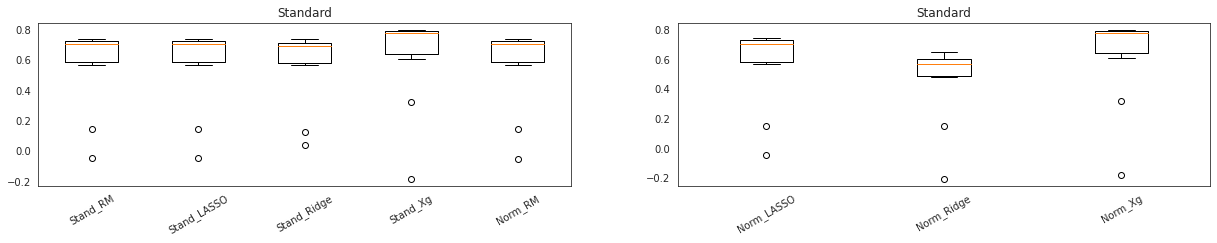

In [323]:
# boxplot de comparação dos algoritmos para cada pré-processamento
fig = plt.figure(figsize=(21,3))

for i in range(2):
  j = i*5
  k=(i+1)*5
  ax = fig.add_subplot(1,2,i+1) 
  plt.boxplot(results[j:k]) 
  ax.set_xticklabels(names[j:k])
  plt.xticks(rotation=30)
  ax.set_title(preprosetps[j])

plt.show()